# Imports

In [1]:
import copy
import glob
import itertools
import numpy as np
import os
import h5py
import scipy
import sys
import tqdm
import verdict
import unyt
import warnings

In [2]:
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as patheffects
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import matplotlib.image as mpimg
import palettable

In [3]:
import kalepy as kale

In [4]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.plot_data.plotting as plotting

In [5]:
from py2tex import py2tex

In [6]:
import trove
import trove.config_parser

In [7]:
import helpers

# Load Data

In [8]:
pm = {
    'mu': 0.6,
    'spin_parameter': 0.035, # Spin parameter
    'used_variations': [
        'm12i',
        'm12m',
        'm11a',
        'm11b',
        'm11c',
        'm12i_md',
        'm12r_md',
        'm12w_md',
        'm12f_md',
        'm12z_md',
        'm12c_md',
        'm12b_md',
        'm11d_md',
        'm11e_md',
        'm11h_md',
        'm11i_md',
        'm11q_md',
        # 'm12i_cr',
    ]
}

In [9]:
config_fp = '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove'
pm = trove.link_params_to_config(
    config_fp,
    variation = 'm12i_md',
    variation = 'relative_to_accretion',
    **pm
)
cp = pm['config_parser']

In [10]:
variations = pm['used_variations']

In [11]:
data_filepath = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_filepath )

/home1/03057/zhafen/repos/verdict/verdict.py:1402: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if hasattr( a[first_element_index][0], 'decode' ):


In [12]:
base_processed_data_dir = pm['config_parser'].get( 'DEFAULT', 'processed_data_dir' )
default_data_fp = os.path.join( base_processed_data_dir, 'summary.hdf5' )
default_data = verdict.Dict.from_hdf5( default_data_fp, create_nonexistent=True )

In [13]:
h_param = .702

## Halo Quantities

In [14]:
mvir = verdict.Dict({})
mstar = verdict.Dict({})
vc = verdict.Dict({})
rstar = verdict.Dict({})
rvir = verdict.Dict({})
Tvir = verdict.Dict({})
for key in tqdm.tqdm( cp.variations ):
    
    # Load from summary data if available
    all_data_types_in_summary_data = True
    for data_type in [ 'Mvir', 'Mstar', 'Vc', 'Rstar0.5', 'Rvir', 'Tvir' ]:
        if data_type not in data:
            data[data_type] = {}
        all_data_types_in_summary_data = all_data_types_in_summary_data & ( key in data[data_type] )
    if all_data_types_in_summary_data:
        mvir[key] = data['Mvir'][key]
        mstar[key] = data['Mstar'][key]
        vc[key] = data['Vc'][key]
        rstar[key] = data['Rstar0.5'][key]
        rvir[key] = data['Rvir'][key]
        Tvir[key] = data['Tvir'][key]
        continue
    
    pm_i = trove.link_params_to_config(
        '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
        variation = key,
        global_variation = pm['global_variation']
    )
    
    h_data = halo_data.HaloData(
        data_dir = pm_i['halo_data_dir'],
        mt_kwargs = { 'tag': 'smooth' },
    )
    
    mvir[key] =  h_data.get_mt_data( 'Mvir', snums=[600,] )[0] / h_param
    mstar[key] = h_data.get_mt_data( 'M_star', snums=[600,] )[0] / h_param
    vc[key] = h_data.get_mt_data( 'Vmax', snums=[600,] )[0]
    rstar[key] = h_data.get_mt_data( 'Rstar0.5', snums=[600,] )[0] / h_param
    rvir[key] = h_data.get_mt_data( 'Rvir', snums=[600,] )[0] / h_param
    Tvir[key] = ( ( unyt.G * pm['mu'] * unyt.mp * mvir[key] * unyt.Msun) / ( 2. * unyt.kb * rvir[key] * unyt.kpc ) ).to( 'K' )
    
    data['Mvir'][key] = mvir[key]
    data['Mstar'][key] = mstar[key]
    data['Vc'][key] = vc[key]
    data['Rstar0.5'][key] = rstar[key]
    data['Rvir'][key] = rvir[key]
    data['Tvir'][key] = Tvir[key]
    

100%|██████████| 18/18 [00:00<00:00, 77993.26it/s]


## Aligned Fraction

In [15]:
# Disk fraction
disk_frac = verdict.Dict({})
smooth_disk_frac = verdict.Dict({})
delta_disk_frac = verdict.Dict({})
delta_smooth_disk_frac = verdict.Dict({})
for key in pm['used_variations']:
    disk_fracs = []
    for i, pdf in enumerate( data['cosphi']['pdf'][key] ):
        
        in_disk = np.abs( data['cosphi']['points'][key] ) < pm['disk_costheta']
        disk_fracs.append( pdf[in_disk].sum()/pdf.sum() )
    disk_frac[key] = disk_fracs
    
    smooth_disk_frac[key] = scipy.signal.savgol_filter(
        disk_fracs,
        window_length = 9,
        polyorder = 1,
    )
    
    interp = scipy.interpolate.interp1d( data['cosphi']['t_tchange_centers'][key] * 1e3, disk_frac[key] )
    delta_disk_frac[key] = interp( pm['aligned_fraction_post_dt'] ) - interp( pm['aligned_fraction_pre_dt'] )
    interp = scipy.interpolate.interp1d( data['cosphi']['t_tchange_centers'][key] * 1e3, smooth_disk_frac[key] )
    delta_smooth_disk_frac[key] = interp( pm['aligned_fraction_post_dt'] ) - interp( pm['aligned_fraction_pre_dt'] )

In [16]:
# Angular Momentum Disk fraction
jdisk_frac = verdict.Dict({})
smooth_jdisk_frac = verdict.Dict({})
delta_jdisk_frac = verdict.Dict({})
delta_smooth_jdisk_frac = verdict.Dict({})
for key in pm['used_variations']:
    jdisk_fracs = []
    for i, pdf in enumerate( data['jzjmag']['pdf'][key] ):
        
        in_disk = data['jzjmag']['points'][key] > pm['disk_jzjmag']
        jdisk_fracs.append( pdf[in_disk].sum()/pdf.sum() )
    jdisk_frac[key] = jdisk_fracs
    
    smooth_jdisk_frac[key] = scipy.signal.savgol_filter(
        jdisk_fracs,
        window_length = 9,
        polyorder = 1,
    )
    
    interp = scipy.interpolate.interp1d( data['jzjmag']['t_tchange_centers'][key] * 1e3, jdisk_frac[key] )
    delta_jdisk_frac[key] = interp( pm['aligned_fraction_post_dt'] ) - interp( pm['aligned_fraction_pre_dt'] )
    interp = scipy.interpolate.interp1d( data['jzjmag']['t_tchange_centers'][key] * 1e3, smooth_jdisk_frac[key] )
    delta_smooth_jdisk_frac[key] = interp( pm['aligned_fraction_post_dt'] ) - interp( pm['aligned_fraction_pre_dt'] )

## Easy access dict

In [17]:
values = {
    'thin_disk_frac': default_data['thin_disk_fraction'],
    'thin_disk_frac_recent': default_data['thin_disk_fraction_recent'],
    'mvir': mvir,
    'mstar': mstar,
    'rstar': rstar,
    'Tvir': Tvir,
    'smooth_disk_frac': smooth_disk_frac,
    'delta_smooth_disk_frac': delta_smooth_disk_frac,
    'smooth_jdisk_frac': smooth_jdisk_frac,
    'delta_smooth_jdisk_frac': delta_smooth_jdisk_frac,
}

# Global Settings

In [18]:
x_label = helpers.get_t_tchange_label( pm )

In [19]:
labels = helpers.quantity_labels

In [20]:
logscale = [ 'mvir', 'mstar', 'tcool_tff' ]

In [21]:
fractions = [
    'thin_disk_frac',
    'thin_disk_frac_recent',
    'thin_disk_frac_tracked',
    'thin_disk_frac_sloanr',
    'quiet_frac',
    'quiet_frac_strict',
]

In [22]:
custom_lims = {
    'median_R1e5K_rgal': [ 0, 4 ],
    'mvir': [ 3e10, 2e12 ],
    'mstar': [ 7e7, 2e11 ],
    'tcool_tff': [ 0.08, 30 ],
    'delta_smooth_disk_frac': [ -0.04, 0.36 ],
}

In [23]:
def get_lim( vs, is_log, v_key, scale_upper=1., scale_lower=1. ):
    
    if v_key in custom_lims:
        return custom_lims[v_key]
    
    if v_key in fractions:
        return [ 0, 1 ]
    
    min_v = np.nanmin( vs.array() )
    if not is_log:
        min_v = min( 0, min_v )
        
    max_v = np.nanmax( vs.array() ) * scale_upper
    min_v *= scale_lower
                      
    return min_v, max_v

In [24]:
pm['aligned_fraction_pre_dt']

-1000

In [25]:
x_min = min(pm['aligned_fraction_pre_dt'], -500)
x_max = max(pm['aligned_fraction_post_dt'], 50)

# Combined Plot

## Setup

In [26]:
nrows = 19
ncols = 1
fig = plt.figure( figsize=(12 * ncols, 4 * nrows), facecolor='w' )

gs = gridspec.GridSpec( ncols=ncols, nrows=nrows, )
gs.update( wspace=0.50, )
leftlabelpad = 45.
rightlabelpad = 65.

def labelpad( i ):
    if i - (i//ncols) * ncols:
        return rightlabelpad
    else:
        return leftlabelpad

errt = 30./2.

rotation = 45.

panel_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

i = 0

<Figure size 1800x11400 with 0 Axes>

In [27]:
inds2 = np.arange(-50,100)

In [28]:
cmap = palettable.matplotlib.Viridis_20.mpl_colormap

In [29]:
mean_disk_frac = values['delta_smooth_disk_frac'].array().mean()
def choose_j( key ):

    return 0
#     return values['thin_disk_frac_recent'][key] > 0.5
#     return values['delta_smooth_disk_frac'][key] > mean_disk_frac


In [30]:
# z_key = 'mvir'
z_key = 'thin_disk_frac_recent'
zs = values[z_key]
z_log = z_key in logscale
z_lims = get_lim( zs, z_log, z_key, )

## Temperature

In [31]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]

        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )

        # Plot T
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['temperature']['median']
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 3,
        )
    #     ax.fill_between(
    #         time,
    #         low_gas_temp,
    #         high_gas_temp,
    #         color = 'k',
    #         alpha = 0.1,
    #     )
    
        ax.annotate(
            text = key,
            xy = ( -400, scipy.interpolate.interp1d( x, y )(-400) )
        )
    
    ax.annotate(
        text = panel_letters[i],
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        bbox = dict(boxstyle='round', facecolor='w')
    )

    # Label lines
    ax.axhline(
        10.**pm['logTcools'],
        color = pm['background_linecolor'],
        linewidth = 1,
    )

    ax.set_xlim( -500, 500 )
    ax.set_ylim( 1e2, 1e6 )
    ax.set_ylabel(
        'T [K]',
        fontsize=22,
        rotation=rotation,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.set_yscale( 'log' )
    ax.set_yticks( [1e2, 1e3, 1e4, 1e5, 1e6 ] )
    ax.set_yticklabels( [ '100', '1000', r'$10^4$', r'$10^5$', r'$10^6$'] )
    ax.tick_params( right=True, labelright=True, )
i += 1

## Radius

In [32]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]
        
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )

        # Plot T
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['radius']['median'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 3,
        )

    ax.annotate(
        text = panel_letters[i],
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        bbox = dict(boxstyle='round', facecolor='w')
    )

    # ax.axvline(
    #     0.,
    #     linewidth = 1.5,
    #     linestyle = '--',
    #     color = '0.1',
    # )
    # ax.axhline(
    #     r_med[0],
    #     linewidth = 1.5,
    #     linestyle = '--',
    #     color = pm['background_linecolor'],
    # )
    # ax.annotate(
    #     text =r'$R(t=t_{10^5{\rm K}})$',
    #     xy = ( 0, r_med[0] ),
    #     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    #     xytext = ( 5, 5 ),
    #     textcoords = 'offset points',
    #     fontsize = 22,
    #     ha = 'left',
    #     va = 'bottom',
    # )

#     ax.axhline(
#         w.r_gal[0],
#         color = pm['background_linecolor'],
#         linewidth = 1,
#     )
#     ax.annotate(
#     #     text =r'$4 r_\star(z=0)$',
#         text =r'$r_{\rm gal}$',
#     #     text ='disk radius',
#         xy = ( 0, w.r_gal[0] ),
#         xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#         xytext = ( 5, 5 ),
#         textcoords = 'offset points',
#         fontsize = 22,
#         ha = 'left',
#         va = 'bottom',
#         color = pm['background_linecolor'],
#         fontweight = 'bold',
#     )

    ax.set_xlim( -500, 500 )
#     ax.set_ylim( 0, r_high[(time>-500.)&(time<500.)].max() )
    # ax.set_yscale( 'log' )
    ax.set_ylim( 0, 100 )
    ax.set_ylabel(
        'r [kpc]',
        fontsize=22,
        rotation=rotation,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )

#     ax_r = ax.twinx()
#     ax_ylim = ax.get_ylim()
# #     ax_r.set_ylim( np.array( ax_ylim ) / w.r_vir[600] )
#     ax_r.set_ylabel( r'r/$r_{\rm vir}(z=0)$', fontsize=22 )

# ax.tick_params( right=True, labelright=True, )
i += 1


## Vertical Height

In [33]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]
        
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )

        # Plot T
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['absolute_height']['median'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 3,
        )

    ax.annotate(
        text = panel_letters[i],
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        bbox = dict(boxstyle='round', facecolor='w')
    )

    # ax.axvline(
    #     0.,
    #     linewidth = 1.5,
    #     linestyle = '--',
    #     color = '0.1',
    # )
    # ax.axhline(
    #     r_med[0],
    #     linewidth = 1.5,
    #     linestyle = '--',
    #     color = pm['background_linecolor'],
    # )
    # ax.annotate(
    #     text =r'$R(t=t_{10^5{\rm K}})$',
    #     xy = ( 0, r_med[0] ),
    #     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    #     xytext = ( 5, 5 ),
    #     textcoords = 'offset points',
    #     fontsize = 22,
    #     ha = 'left',
    #     va = 'bottom',
    # )

#     ax.axhline(
#         w.r_gal[0],
#         color = pm['background_linecolor'],
#         linewidth = 1,
#     )
#     ax.annotate(
#     #     text =r'$4 r_\star(z=0)$',
#         text =r'$r_{\rm gal}$',
#     #     text ='disk radius',
#         xy = ( 1, w.r_gal[0] ),
#         xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
#         xytext = ( -5, -5 ),
#         textcoords = 'offset points',
#         fontsize = 22,
#         ha = 'right',
#         va = 'top',
#         color = pm['background_linecolor'],
#         fontweight = 'bold',
#     )

    ax.set_xlim( -500, 500 )
    ax.set_ylim( 0, 50 )
    ax.set_ylabel(
        r'$\mid z \mid$ [kpc]',
        fontsize=22,
        rotation=rotation,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )

# ax.tick_params( right=True, labelright=True, )
i += 1

## Tangential velocity

In [34]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]
        
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )

        # Plot T
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['tangential_velocity']['median'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 3,
        )

    ax.annotate(
        text = panel_letters[i],
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        bbox = dict(boxstyle='round', facecolor='w')
    )

    ax.axhline(
        0,
        color = pm['background_linecolor'],
        linewidth = 0.5,
    )

    # c_hot = 100. * np.sqrt( w.t_vir[snum] / 4.5e5 )
    # ax.axhline(
    #     c_hot,
    #     color = pm['background_linecolor'],
    #     linewidth = 1.,
    # )
    # ax.axhline(
    #     -c_hot,
    #     color = pm['background_linecolor'],
    #     linewidth = 1.,
    # )
    # ax.annotate(
    #     text = r'$c_s(T_{\rm vir})$',
    #     xy = ( 300, -c_hot ),
    #     xycoords = 'data',
    #     xytext = ( 0, 5 ),
    #     textcoords = 'offset points',
    #     va = 'bottom',
    #     ha = 'left',
    #     fontsize = 22,
    #     color = pm['background_linecolor'],
    # )

    ax.set_yticks( np.arange( -1000, 1000, 50 ) )

    ax.set_xlim( -500, 500 )
    ax.set_ylim( 0, 300 )
    ax.set_ylabel(
        r'$v_{\phi}$' + '\n[km/s]',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    # ax.set_yscale( 'log' )
    ax.tick_params( right=True, labelright=True, )
    
i += 1

## Radial velocity

In [35]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]
        
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )

        # Plot T
        x = data['before_after_plot_data'][key]['time']
        y = np.abs( data['before_after_plot_data'][key]['radial_velocity']['median'][inds2] )
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 3,
        )

    ax.annotate(
        text = panel_letters[i],
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        bbox = dict(boxstyle='round', facecolor='w')
    )

    ax.axhline(
        0,
        color = pm['background_linecolor'],
        linewidth = 0.5,
    )

    # c_hot = 100. * np.sqrt( w.t_vir[snum] / 4.5e5 )
    # ax.axhline(
    #     c_hot,
    #     color = pm['background_linecolor'],
    #     linewidth = 1.,
    # )
    # ax.axhline(
    #     -c_hot,
    #     color = pm['background_linecolor'],
    #     linewidth = 1.,
    # )
    # ax.annotate(
    #     text = r'$c_s(T_{\rm vir})$',
    #     xy = ( 300, -c_hot ),
    #     xycoords = 'data',
    #     xytext = ( 0, 5 ),
    #     textcoords = 'offset points',
    #     va = 'bottom',
    #     ha = 'left',
    #     fontsize = 22,
    #     color = pm['background_linecolor'],
    # )

    ax.set_yticks( np.arange( -1000, 1000, 50 ) )

    ax.set_xlim( x_min, x_max )
    ax.set_ylim( 0, 200 )
    ax.set_ylabel(
        r'$v_{\rm r}$' + '\n[km/s]',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    # ax.set_yscale( 'log' )
    ax.tick_params( right=True, labelright=True, )
    
i += 1

## Mach Number

In [36]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]
        
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )

        # Plot T
        cs_hot = 100. * np.sqrt( values['Tvir'][key] / 4.5e5 )
        x = data['before_after_plot_data'][key]['time']
        y = np.abs( data['before_after_plot_data'][key]['radial_velocity']['median'][inds2] ) / cs_hot
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 3,
        )

    ax.annotate(
        text = panel_letters[i],
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        bbox = dict(boxstyle='round', facecolor='w')
    )

    ax.axhline(
        0,
        color = pm['background_linecolor'],
        linewidth = 0.5,
    )

    # c_hot = 100. * np.sqrt( w.t_vir[snum] / 4.5e5 )
    # ax.axhline(
    #     c_hot,
    #     color = pm['background_linecolor'],
    #     linewidth = 1.,
    # )
    # ax.axhline(
    #     -c_hot,
    #     color = pm['background_linecolor'],
    #     linewidth = 1.,
    # )
    # ax.annotate(
    #     text = r'$c_s(T_{\rm vir})$',
    #     xy = ( 300, -c_hot ),
    #     xycoords = 'data',
    #     xytext = ( 0, 5 ),
    #     textcoords = 'offset points',
    #     va = 'bottom',
    #     ha = 'left',
    #     fontsize = 22,
    #     color = pm['background_linecolor'],
    # )
    
    ax.axhline(
        1,
        color = pm['background_linecolor'],
        linewidth = 1,
    )

    ax.set_xlim( x_min, x_max )
    ax.set_ylim( 0, 1.8 )
    ax.set_ylabel(
        r'$\mathcal{M}= \frac{v_r}{ c_s(T_{\rm vir}, z=0) }$',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    # ax.set_yscale( 'log' )
    ax.tick_params( right=True, labelright=True, )
    
i += 1

## Angular momentum

### Alignment

In [37]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['angular_momentum_alignment']['low'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
        ax.annotate(
            text = key,
            xy = ( -400, scipy.interpolate.interp1d( x, y )(-400) )
        )
        
#     y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -400 )
#     text = ax.annotate(
#         text =r'$L_z$ / $\vert \vec L \vert$',
#         xy = ( -400, y_annot ),
#         xycoords = 'data',
#         xytext = ( 30, -10 ),
#         textcoords = 'offset points',
#         fontsize = 24,
#         ha = 'left',
#         va = 'top',
#         color = 'k',
#         fontweight = 'bold',
#         arrowprops = {
#             'arrowstyle': '-',
#             'lw': 2,
#             'color': 'k',
#         },
#     )

    # # Net jz/j in bins
    # for i, jz_jmag in enumerate( mean_jz_jmag ):
    #     ax.plot(
    #         time,
    #         jz_jmag[inds2],
    #         color = 'k',
    #         alpha = n_bin[i]/n_bin.max(),
    #         linewidth = 2,
    #         linestyle = '--',
    #     )

#     # Net jz/j
#     ax.plot(
#         time,
#         total_jz_jmag[inds2],
#         color = 'k',
#         linestyle = '--',
#         linewidth = 2,
#     )
    # y_annot = scipy.interpolate.interp1d( time, total_jz_jmag[inds2] )( -500 )
    # ax.annotate(
    #     text =r'$L_z$ / $\mid \vec L \mid$',
    #     xy = ( 0, y_annot ),
    #     xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
    #     xytext = ( 5, -2.5 ),
    #     textcoords = 'offset points',
    #     va = 'top',
    #     ha = 'left',
    #     fontsize = 22,
    # )

    # # Circulation
    # ax.plot(
    #     time,
    #     circulation[inds2],
    #     color = 'k',
    #     linestyle = '-.',
    #     linewidth = 2,
    # )
    
    # y_annot = scipy.interpolate.interp1d( time, np.nanpercentile( c, 84., axis=0 )[inds2] )( -100 )
    ax.annotate(
        text = panel_letters[i],
        xy = ( 1, 1 ),
        xycoords = 'axes fraction',
        xytext = ( -10, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        bbox = dict(boxstyle='round', facecolor='w')
    )
    
    ax.axhline(
        1,
        color = pm['background_linecolor'],
        linewidth = 1,
    )
    text = ax.annotate(
        text ='co-rotating',
        xy = ( 0.92, 1 ),
        xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
        xytext = ( -5, -10 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        color = pm['background_linecolor'],
    )
    text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])
    ax.axhline(
        0,
        color = pm['background_linecolor'],
        linewidth = 0.5,
    )
    text = ax.annotate(
        text ='perpendicular',
        xy = ( 0.92, 0 ),
        xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
        xytext = ( -5, -5 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'right',
        fontsize = 22,
        color = pm['background_linecolor'],
    )
    text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])
    text = ax.annotate(
        text ='counter-rotating',
        xy = ( 0.92, -1 ),
        xycoords = matplotlib.transforms.blended_transform_factory( ax.transAxes, ax.transData ),
        xytext = ( -5, 5 ),
        textcoords = 'offset points',
        va = 'bottom',
        ha = 'right',
        fontsize = 22,
        color = pm['background_linecolor'],
    )
    text.set_path_effects([ patheffects.Stroke(linewidth=4, foreground='white'), patheffects.Normal() ])

    ax.set_xlim( -500, 500 )
    ax.set_ylim( -1, 1 )
    ax.set_ylabel(
        r'$j_z$ / $\mid \vec j \mid$',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
    
i += 1

### Magnitude

In [38]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['angular_momentum_magnitude']['median'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
    ax.set_xlim( -500, 500 )
    ax.set_ylim( 0, 8000. )
    ax.set_ylabel(
        r'$\vert j \vert$ [kpc km/s]',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
        
i += 1

### Aligned value

In [39]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['aligned_angular_momentum']['median'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
    ax.set_xlim( -500, 500 )
    ax.set_ylim( 0, 4900. )
    ax.set_ylabel(
        r'$j_z$ [kpc km/s]',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
        
i += 1

### Perpendicular value

In [40]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['perpendicular_angular_momentum']['median'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
    ax.set_xlim( -500, 500 )
    ax.set_ylim( 0, 4900. )
    ax.set_ylabel(
        r'$j_\perp$ [kpc km/s]',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
        
i += 1

### Change in Perpendicular value

In [41]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['perpendicular_angular_momentum']['median'][inds2]
        y -= scipy.interpolate.interp1d( x, y )( pm['aligned_fraction_pre_dt'] )
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
    ax.axhline(
        0,
        color = pm['background_linecolor'],
        linewidth = 1,
    )
        
    ax.set_xlim( -500, 500 )
    ax.set_ylim( -4000, 500. )
    ax.set_ylabel(
        r'$j_\perp - j_{\perp,0}$' + '\n[kpc km/s]',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
        
i += 1

### Fractional Change in Perpendicular value

In [42]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['perpendicular_angular_momentum']['median'][inds2]
        y -= scipy.interpolate.interp1d( x, y )( pm['aligned_fraction_pre_dt'])
        y /= np.sqrt( 2. ) * pm['spin_parameter'] * rvir[key] * vc[key]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
    ax.axhline(
        0,
        color = pm['background_linecolor'],
        linewidth = 1,
    )
        
    ax.set_xlim( -500, 500 )
    ax.set_ylim( -1.5, 0.5 )
    ax.set_ylabel(
        r'$(j_\perp - j_{\perp,0})/j_{\rm DM}$',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
        
i += 1

### Support

In [43]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['angular_momentum_magnitude']['median'][inds2]
        y /= data['before_after_plot_data'][key]['circular_angular_momentum']['median'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
    ax.axhline(
        1,
        color = pm['background_linecolor'],
        linewidth = 1,
    )
        
    ax.set_xlim( -500, 500 )
    ax.set_ylim( 0, 1.1 )
    ax.set_ylabel(
        r'$\vert j \vert / ( r v_c(r)$ [kpc km/s]',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
        
i += 1

## Torque

### Magnitude

In [44]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['torque_magnitude']['median'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
    ax.set_ylim( 0, 50 )
    ax.set_xlim( -500, 500 )
    ax.set_ylabel(
        r'$\vert \vec \tau \vert$' + '\n[kpc km/s/Myr]',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
        
i += 1

### Perpendicular

In [45]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['perpendicular_torque']['median'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
    ax.set_ylim( 0, 30 )
    ax.set_xlim( -500, 500 )
    ax.set_ylabel(
        r'$\vert \tau_\perp \vert$' + '\n[kpc km/s/Myr]',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
        
i += 1

### Aligned

In [46]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['aligned_torque']['median'][inds2]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
    ax.set_ylim( -10, 10 )
    ax.set_xlim( -800, 500 )
    ax.set_ylabel(
        r'$\tau_z$' + '\n[kpc km/s/Myr]',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
        
i += 1

## Density

In [47]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['before_after_plot_data'][key]['time']
        y = data['before_after_plot_data'][key]['density']['median']
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
    ax.set_yscale( 'log' )
    ax.set_xlim( -500, 500 )
    ax.set_ylabel(
        'n [cm$^{-3}$]',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.set_yticks( 10.**np.arange(-5, 7, 1 ) )
    ax.set_ylim( 1e-4, 100 )
    ax.tick_params( right=True, labelright=True, )
        
i += 1

## Disk Fraction

In [48]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['cosphi']['t_tchange_centers'][key] * 1e3
        y = values['smooth_disk_frac'][key]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
    ax.set_xlim( -500, 500 )
    ax.set_ylim( 0, 1 )
    ax.set_ylabel(
        'spatial aligned\naccretion fraction',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
    
i+=1

## Spin Disk Fraction

In [49]:
for j in range( ncols ):
    
    ax = fig.add_subplot( gs[i,j] )

    for k, key in enumerate( variations ):

        if choose_j( key ) != j:
            continue

        z = zs[key]    
    
        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
    
        x = data['jzjmag']['t_tchange_centers'][key] * 1e3
        y = values['smooth_jdisk_frac'][key]
        ax.plot(
            x,
            y,
            color = c,
            linewidth = 5,
        )
        
    ax.set_xlim( -500, 500 )
    ax.set_ylim( 0, 1 )
    ax.set_ylabel(
        'spin aligned\naccretion fraction',
        fontsize=22,
        rotation=45,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
    
i+=1

## Finish up

In [50]:
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [51]:

for i in range( nrows ):
    for j in range( ncols ):

        ax = fig.add_subplot( gs[i,j] )
        
        ax.fill_betweenx(
            [ 0., 1. ],
            [ -errt, ]*2,
            [ errt, ]*2,
            transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
            facecolor = 'none',
            edgecolor = pm['background_linecolor'],
            linewidth = 1.0,
            hatch = '/',
        )
        
        ax.set_xlim( x_min, x_max )

        if ax.is_last_row():
            ax.set_xlabel( x_label, fontsize=22 )
            
        # Set the zorder
        for k, line in enumerate( ax.get_lines() ):
            
            if k >= len( variations ):
                break
            
            key = variations[k]
            
            z = zs[key]
            if not z_log:
                c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
            else:
                c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
                
            line.set_zorder( c_value + 50 )

<ipython-input-51-e3d2730e41d9>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot( gs[i,j] )


## Display

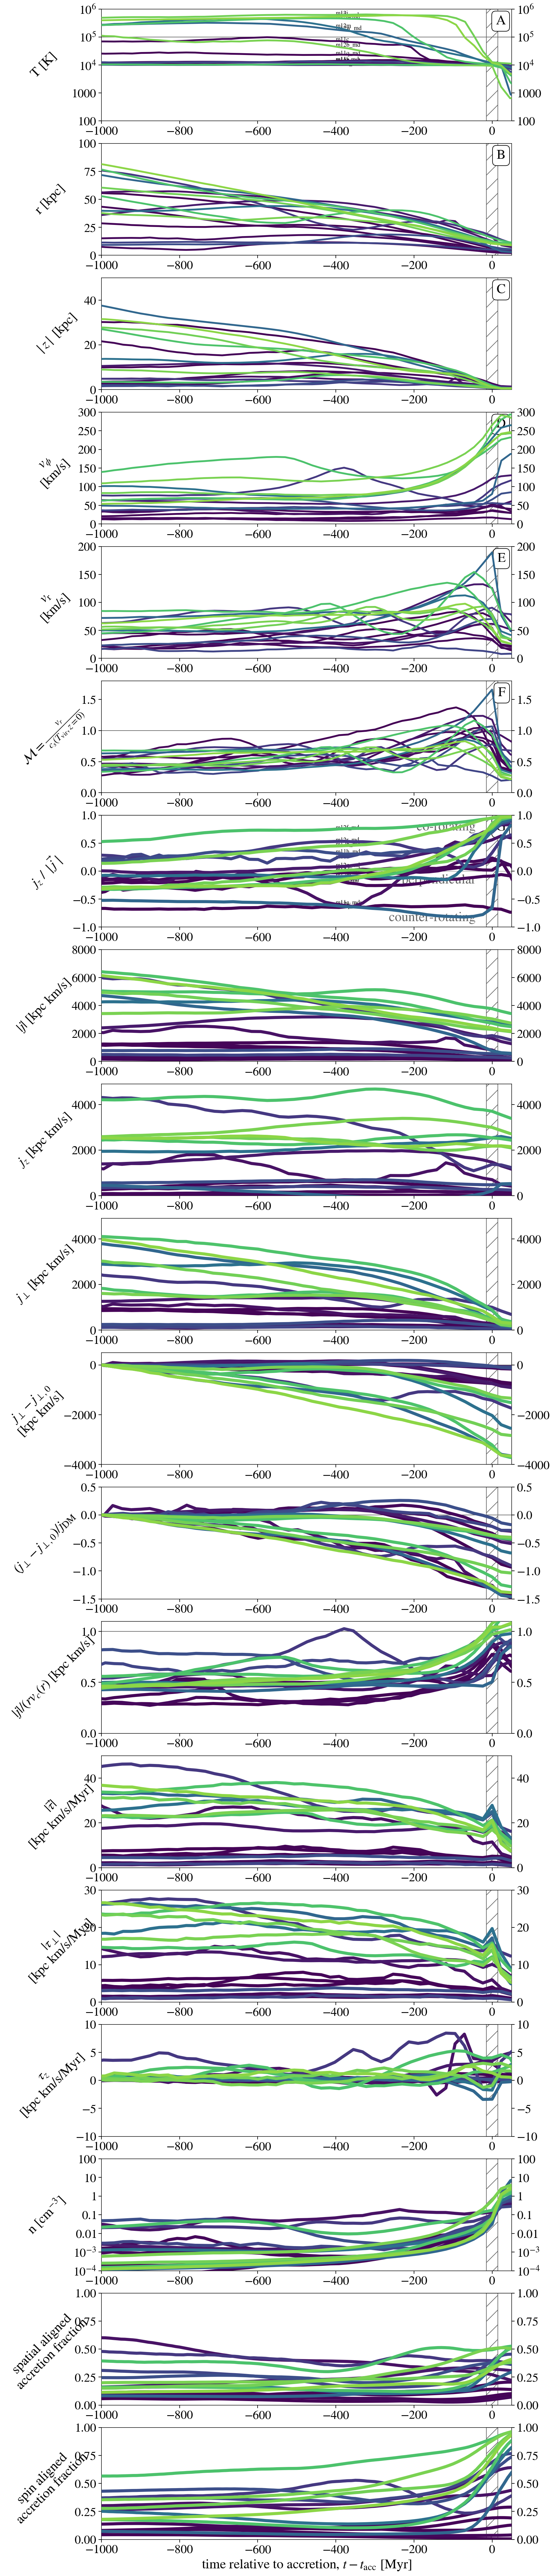

In [52]:
fig

## Save

In [53]:
plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'before_and_after' ),
    save_file = 'before_and_after_manyaline.pdf',
    fig = fig,
)

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/variations/relative_to_accretion/before_and_after/before_and_after_manyaline.pdf


# Bin Averaged

## Get Data

In [54]:
binned_data = {
    'thin_disk': {},
    'irregular': {},
}

In [55]:
def store_binned_data( prop_key, arrs, storage_dict ):
    
    if prop_key not in storage_dict:
        storage_dict[prop_key] = {
            'median': [],
            'high': [],
            'low': [],
        }
    
    for key in storage_dict[prop_key].keys():
        
        arr = arrs[key]
        
        if arr.size != inds2.size:
            assert arr.size == 601
            arr = arr[inds2]
        
        storage_dict[prop_key][key].append( arr )
        

In [56]:
# Do actual storing
for i, key in enumerate( variations ):
    
    if values['thin_disk_frac_recent'][key] > 0.5:
        storage_dict = binned_data['thin_disk']
    else:
        storage_dict = binned_data['irregular']
    
    # Easy to store quantities
    store_binned_data(
        'T',
        data['before_after_plot_data'][key]['temperature'],
        storage_dict
    )
    store_binned_data(
        'R',
        data['before_after_plot_data'][key]['radius'],
        storage_dict
    )
    store_binned_data(
        'a',
        data['before_after_plot_data'][key]['angular_momentum_alignment'],
        storage_dict
    )
    
    # Disk fractions
    if 'f' not in storage_dict:
        storage_dict['f'] = []
    storage_dict['f'].append( values['smooth_disk_frac'][key] )
    if 'F' not in storage_dict:
        storage_dict['F'] = []
    storage_dict['F'].append( values['smooth_jdisk_frac'][key] )
    
    # Height ratio
    zR = {}
    for ikey, z in data['before_after_plot_data'][key]['absolute_height'].items():
        r = data['before_after_plot_data'][key]['radius']['median']
        if z.size != inds2.size:
            z = z[inds2]
        if r.size != inds2.size:
            r = r[inds2]
        zR[ikey] = z / r
    store_binned_data(
        'z',
        zR,
        storage_dict
    )
    
    # Momentum ratio
    jrvc = {}
    for ikey, j in data['before_after_plot_data'][key]['angular_momentum_magnitude'].items():
        rvc = data['before_after_plot_data'][key]['circular_angular_momentum']['median']
        jrvc[ikey] = j / rvc
    store_binned_data(
        's',
        jrvc,
        storage_dict
    )
    # Of total
    if 'total_angular_momentum_alignment' not in storage_dict:
        storage_dict['total_angular_momentum_alignment'] = []
    storage_dict['total_angular_momentum_alignment'].append( data['before_after_plot_data'][key]['angular_momentum_alignment']['of_total'] )

In [57]:
# Calculate
averaged_data = {}
for category_key, storage_dict in binned_data.items():
    averaged_data[category_key] = {}
    for prop_key, item in tqdm.tqdm( storage_dict.items() ):
        averaged_data[category_key][prop_key] = {}
        try:
            for stat_key, stat_arrs in item.items():
                averaged_stat = np.nanmedian( stat_arrs, axis=0 )
                averaged_data[category_key][prop_key][stat_key] = averaged_stat
            averaged_data[category_key][prop_key]['median_max'] = np.nanmax( item['median'], axis=0 )
            averaged_data[category_key][prop_key]['median_min'] = np.nanmin( item['median'], axis=0 )
        except AttributeError:
            averaged_data[category_key][prop_key]['median'] = np.nanmedian( item, axis=0 )
            averaged_data[category_key][prop_key]['max'] = np.nanmax( item, axis=0 )
            averaged_data[category_key][prop_key]['min'] = np.nanmin( item, axis=0 )

100%|██████████| 8/8 [00:00<00:00, 996.39it/s]


## Setup

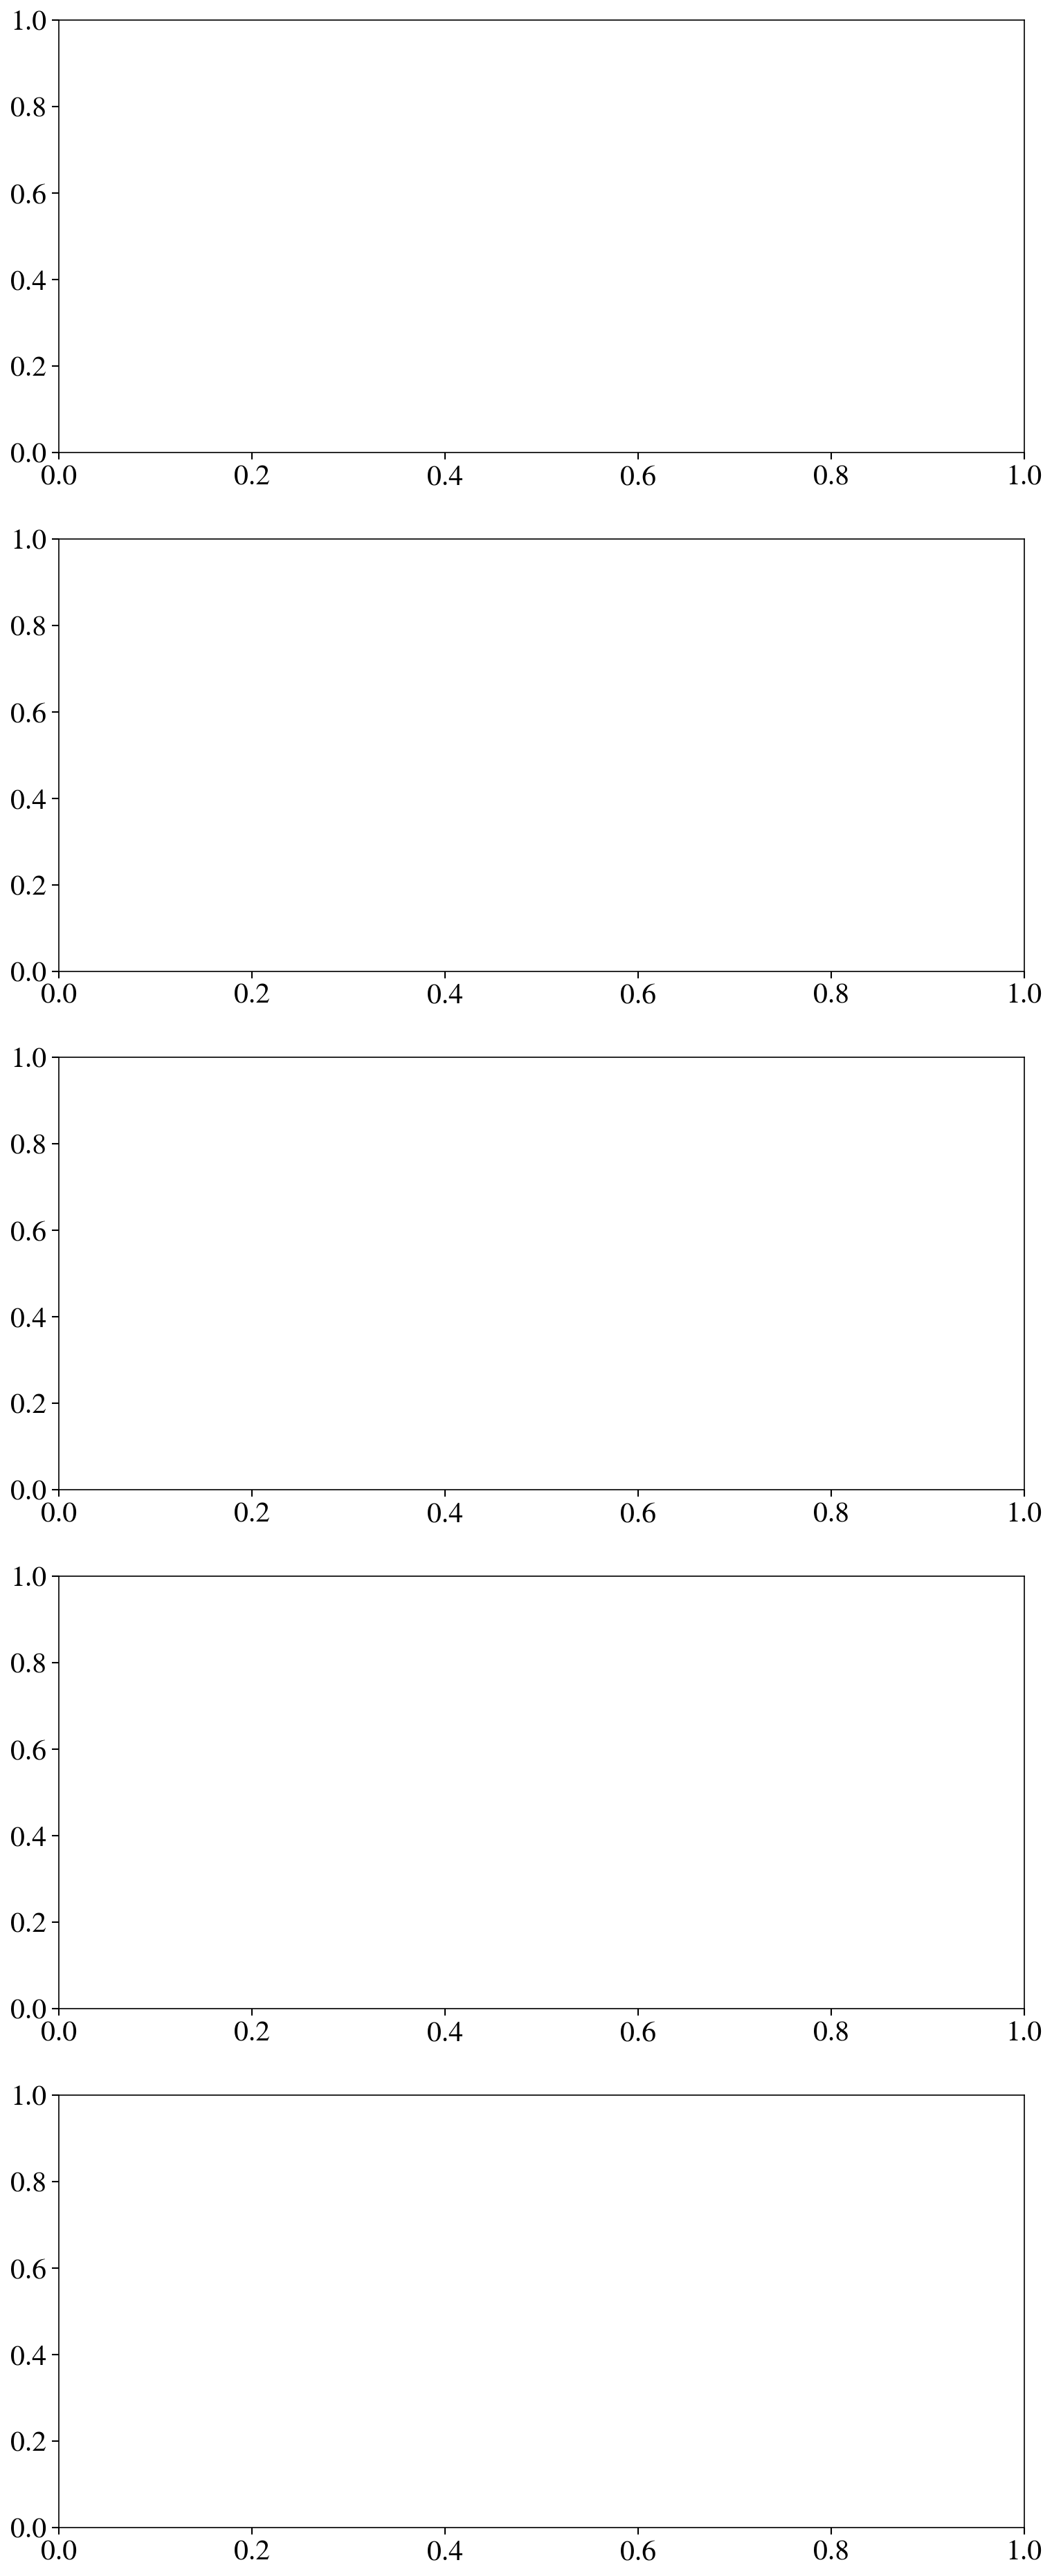

In [58]:
nrows = len( averaged_data['thin_disk'] )
ncols = 1
fig = plt.figure( figsize=(12 * ncols, 4 * nrows), facecolor='w' )

mosaic = [
    [ 'T', ],
    [ 'R', ],
    [ 'z', ],
    [ 's', ],
    [ 'a', ],
]
ax_dict = fig.subplot_mosaic( mosaic )

leftlabelpad = 45.
rightlabelpad = 65.

errt = 30./2.

rotation = 45.

panel_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

linewidth = 4
alphas = {
    'thin_disk': 0.5,
    'irregular': 0.3,
}
zorders = {
    'thin_disk': 10,
    'irregular': 9,
}

outline = True
outline_linewidth = 4.5

i = 0

In [59]:
inds2 = np.arange(-50,100)

In [60]:
cmap = palettable.matplotlib.Plasma_6.mpl_colors
colors = {
    'irregular': cmap[1],
    'thin_disk': cmap[-2],
}

In [61]:
time = data['before_after_plot_data'][key]['time']
time2 = data['cosphi']['t_tchange_centers'][key] * 1e3

## Temperature

In [62]:
prop_key = 'T'

ax = ax_dict[prop_key]

for category_key, storage_dict in averaged_data.items():

    # Plot
    line = ax.plot(
        time,
        storage_dict[prop_key]['median'],
        color = colors[category_key],
        linewidth = linewidth,
        zorder = zorders[category_key],
    )
    if outline:
        line[0].set_path_effects([
            patheffects.Stroke(linewidth=outline_linewidth, foreground='black', ),
            patheffects.Normal()
        ])
    ax.fill_between(
        time,
        storage_dict[prop_key]['low'],
        storage_dict[prop_key]['high'],
        color = colors[category_key],
        alpha = alphas[category_key],
    )

    # Label lines
    ax.axhline(
        10.**pm['logTcools'],
        color = pm['background_linecolor'],
        linewidth = 1,
    )

    ax.set_xlim( -500, 500 )
    ax.set_ylabel(
        'T [K]',
        fontsize=22,
        rotation=rotation,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.set_yscale( 'log' )
    ax.set_yticks( [1e2, 1e3, 1e4, 1e5, 1e6, 1e7 ] )
    ax.set_yticklabels( [ '100', '1000', r'$10^4$', r'$10^5$', r'$10^6$', r'$10^7$' ] )
    ax.set_ylim( 1e3, 1e7 )
    ax.tick_params( right=True, labelright=True, )
i += 1

## Radius

In [63]:
prop_key = 'R'

ax = ax_dict[prop_key]

for category_key, storage_dict in averaged_data.items():

    # Plot
    line = ax.plot(
        time,
        storage_dict[prop_key]['median'],
        color = colors[category_key],
        linewidth = linewidth,
        zorder = zorders[category_key],
    )
    if outline:
        line[0].set_path_effects([
            patheffects.Stroke(linewidth=outline_linewidth, foreground='black', ),
            patheffects.Normal()
        ])
    ax.fill_between(
        time,
        storage_dict[prop_key]['low'],
        storage_dict[prop_key]['high'],
        color = colors[category_key],
        alpha = alphas[category_key],
    )
    
    ax.set_xlim( -500, 500 )
    ax.set_ylim( 0, 62 )
    ax.set_ylabel(
        'R [kpc]',
        fontsize=22,
        rotation=rotation,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
i += 1

## Disk Fraction

In [64]:
# prop_key = 'f'

# ax = ax_dict[prop_key]

# for category_key, storage_dict in averaged_data.items():

#     # Plot
#     line = ax.plot(
#         time2,
#         storage_dict[prop_key]['median'],
#         color = colors[category_key],
#         linewidth = linewidth,
#         zorder = zorders[category_key],
#     )
#     if outline:
#         line[0].set_path_effects([
#             patheffects.Stroke(linewidth=outline_linewidth, foreground='black', ),
#             patheffects.Normal()
#         ])
#     ax.fill_between(
#         time2,
#         storage_dict[prop_key]['min'],
#         storage_dict[prop_key]['max'],
#         color = colors[category_key],
#         alpha = alphas[category_key],
#     )
    
#     ax.annotate(
#         text = panel_letters[i],
#         xy = ( 1, 1 ),
#         xycoords = 'axes fraction',
#         xytext = ( -10, -10 ),
#         textcoords = 'offset points',
#         va = 'top',
#         ha = 'right',
#         fontsize = 22,
#         bbox = dict(boxstyle='round', facecolor='w')
#     )
    
#     ax.set_xlim( -500, 500 )
#     ax.set_ylim( 0, 1 )
#     ax.set_ylabel(
#         'spatial aligned\naccretion fraction',
#         fontsize=22,
#         rotation=rotation,
#         va='center',
#         ha='center',
#         labelpad = labelpad( i ),
#     )
#     ax.tick_params( right=True, labelright=True, )
# i += 1

## Spin Disk Fraction

In [65]:
# prop_key = 'F'

# ax = ax_dict[prop_key]

# for category_key, storage_dict in averaged_data.items():

#     # Plot
#     line = ax.plot(
#         time2,
#         storage_dict[prop_key]['median'],
#         color = colors[category_key],
#         linewidth = linewidth,
#         zorder = zorders[category_key],
#     )
#     if outline:
#         line[0].set_path_effects([
#             patheffects.Stroke(linewidth=outline_linewidth, foreground='black', ),
#             patheffects.Normal()
#         ])
#     ax.fill_between(
#         time2,
#         storage_dict[prop_key]['min'],
#         storage_dict[prop_key]['max'],
#         color = colors[category_key],
#         alpha = alphas[category_key],
#     )
    
#     ax.annotate(
#         text = panel_letters[i],
#         xy = ( 1, 1 ),
#         xycoords = 'axes fraction',
#         xytext = ( -10, -10 ),
#         textcoords = 'offset points',
#         va = 'top',
#         ha = 'right',
#         fontsize = 22,
#         bbox = dict(boxstyle='round', facecolor='w')
#     )
    
#     ax.set_xlim( -500, 500 )
#     ax.set_ylim( 0, 1 )
#     ax.set_ylabel(
#         'spin aligned\naccretion fraction',
#         fontsize=22,
#         rotation=rotation,
#         va='center',
#         ha='center',
#         labelpad = labelpad( i ),
#     )
#     ax.tick_params( right=True, labelright=True, )
# i += 1

## Alignment

In [66]:
prop_key = 'z'

ax = ax_dict[prop_key]

for category_key, storage_dict in averaged_data.items():

    # Plot
    line = ax.plot(
        time,
        storage_dict[prop_key]['median'],
        color = colors[category_key],
        linewidth = linewidth,
        zorder = zorders[category_key],
    )
    if outline:
        line[0].set_path_effects([
            patheffects.Stroke(linewidth=outline_linewidth, foreground='black', ),
            patheffects.Normal()
        ])
    ax.fill_between(
        time,
        storage_dict[prop_key]['median_min'],
        storage_dict[prop_key]['median_max'],
        color = colors[category_key],
        alpha = alphas[category_key],
    )
    
    ax.set_xlim( -500, 500 )
    ax.set_ylim( 0, 0.7 )
    ax.set_ylabel(
        r'$z / r$',
        fontsize=22,
        rotation=rotation,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
i += 1

## Rotational Support

In [67]:
prop_key = 's'

ax = ax_dict[prop_key]

for category_key, storage_dict in averaged_data.items():

    # Plot
    line = ax.plot(
        time,
        storage_dict[prop_key]['median'],
        color = colors[category_key],
        linewidth = linewidth,
        zorder = zorders[category_key],
    )
    if outline:
        line[0].set_path_effects([
            patheffects.Stroke(linewidth=outline_linewidth, foreground='black', ),
            patheffects.Normal()
        ])
    ax.fill_between(
        time,
        storage_dict[prop_key]['median_min'],
        storage_dict[prop_key]['median_max'],
        color = colors[category_key],
        alpha = alphas[category_key],
    )
    
    ax.set_xlim( -500, 500 )
    ax.set_ylim( 0, 1.3 )
    ax.set_ylabel(
        r'$v_{\phi} / v_c(r)$',
        fontsize=22,
        rotation=rotation,
        va='center',
        ha='center',
        labelpad = labelpad( i ),
    )
    ax.tick_params( right=True, labelright=True, )
i += 1

## Angular Momentum Alignment

In [68]:
prop_key = 'a'

ax = ax_dict[prop_key]

for category_key, storage_dict in averaged_data.items():

    # Plot
#     line = ax.plot(
#         time,
#         storage_dict['total_angular_momentum_alignment']['median'][inds2],
#         color = colors[category_key],
#         linewidth = linewidth,
#         zorder = zorders[category_key],
#     )
    line = ax.plot(
        time,
        storage_dict[prop_key]['low'],
        color = colors[category_key],
        linewidth = linewidth,
        zorder = zorders[category_key],
    )
    if outline:
        line[0].set_path_effects([
            patheffects.Stroke(linewidth=outline_linewidth, foreground='black', ),
            patheffects.Normal()
        ])
    ax.fill_between(
        time,
        storage_dict[prop_key]['low'],
        storage_dict[prop_key]['high'],
        color = colors[category_key],
        alpha = alphas[category_key],
    )
    
ax.axhline(
    0,
    c = pm['background_linecolor'],
    linewidth = 1,
)
    
ax.set_xlim( -500, 500 )
ax.set_ylim( -0.3, 1 )
ax.set_ylabel(
    r'$j_z / \vert \vec j \vert$',
    fontsize=22,
    rotation=rotation,
    va='center',
    ha='center',
    labelpad = labelpad( i ),
)
ax.tick_params( right=True, labelright=True, )
i += 1

## Finish up

In [69]:

for i, row in enumerate( mosaic ):
    for j, key in enumerate( row ):
        
        ax = ax_dict[key]

        ax.fill_betweenx(
            [ 0., 1. ],
            [ -errt, ]*2,
            [ errt, ]*2,
            transform = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes ),
            facecolor = 'none',
            edgecolor = pm['background_linecolor'],
            linewidth = 1.0,
            hatch = '/',
        )

        ax.annotate(
            text = panel_letters[i],
            xy = ( 1, 1 ),
            xycoords = 'axes fraction',
            xytext = ( -10, -10 ),
            textcoords = 'offset points',
            va = 'top',
            ha = 'right',
            fontsize = 22,
            bbox = dict(boxstyle='round', facecolor='w'),
            zorder = 100,
        )

        ax.set_xlim( -300, 100 )

        if ax.is_last_row():
            ax.set_xlabel( x_label, fontsize=22 )

## Display

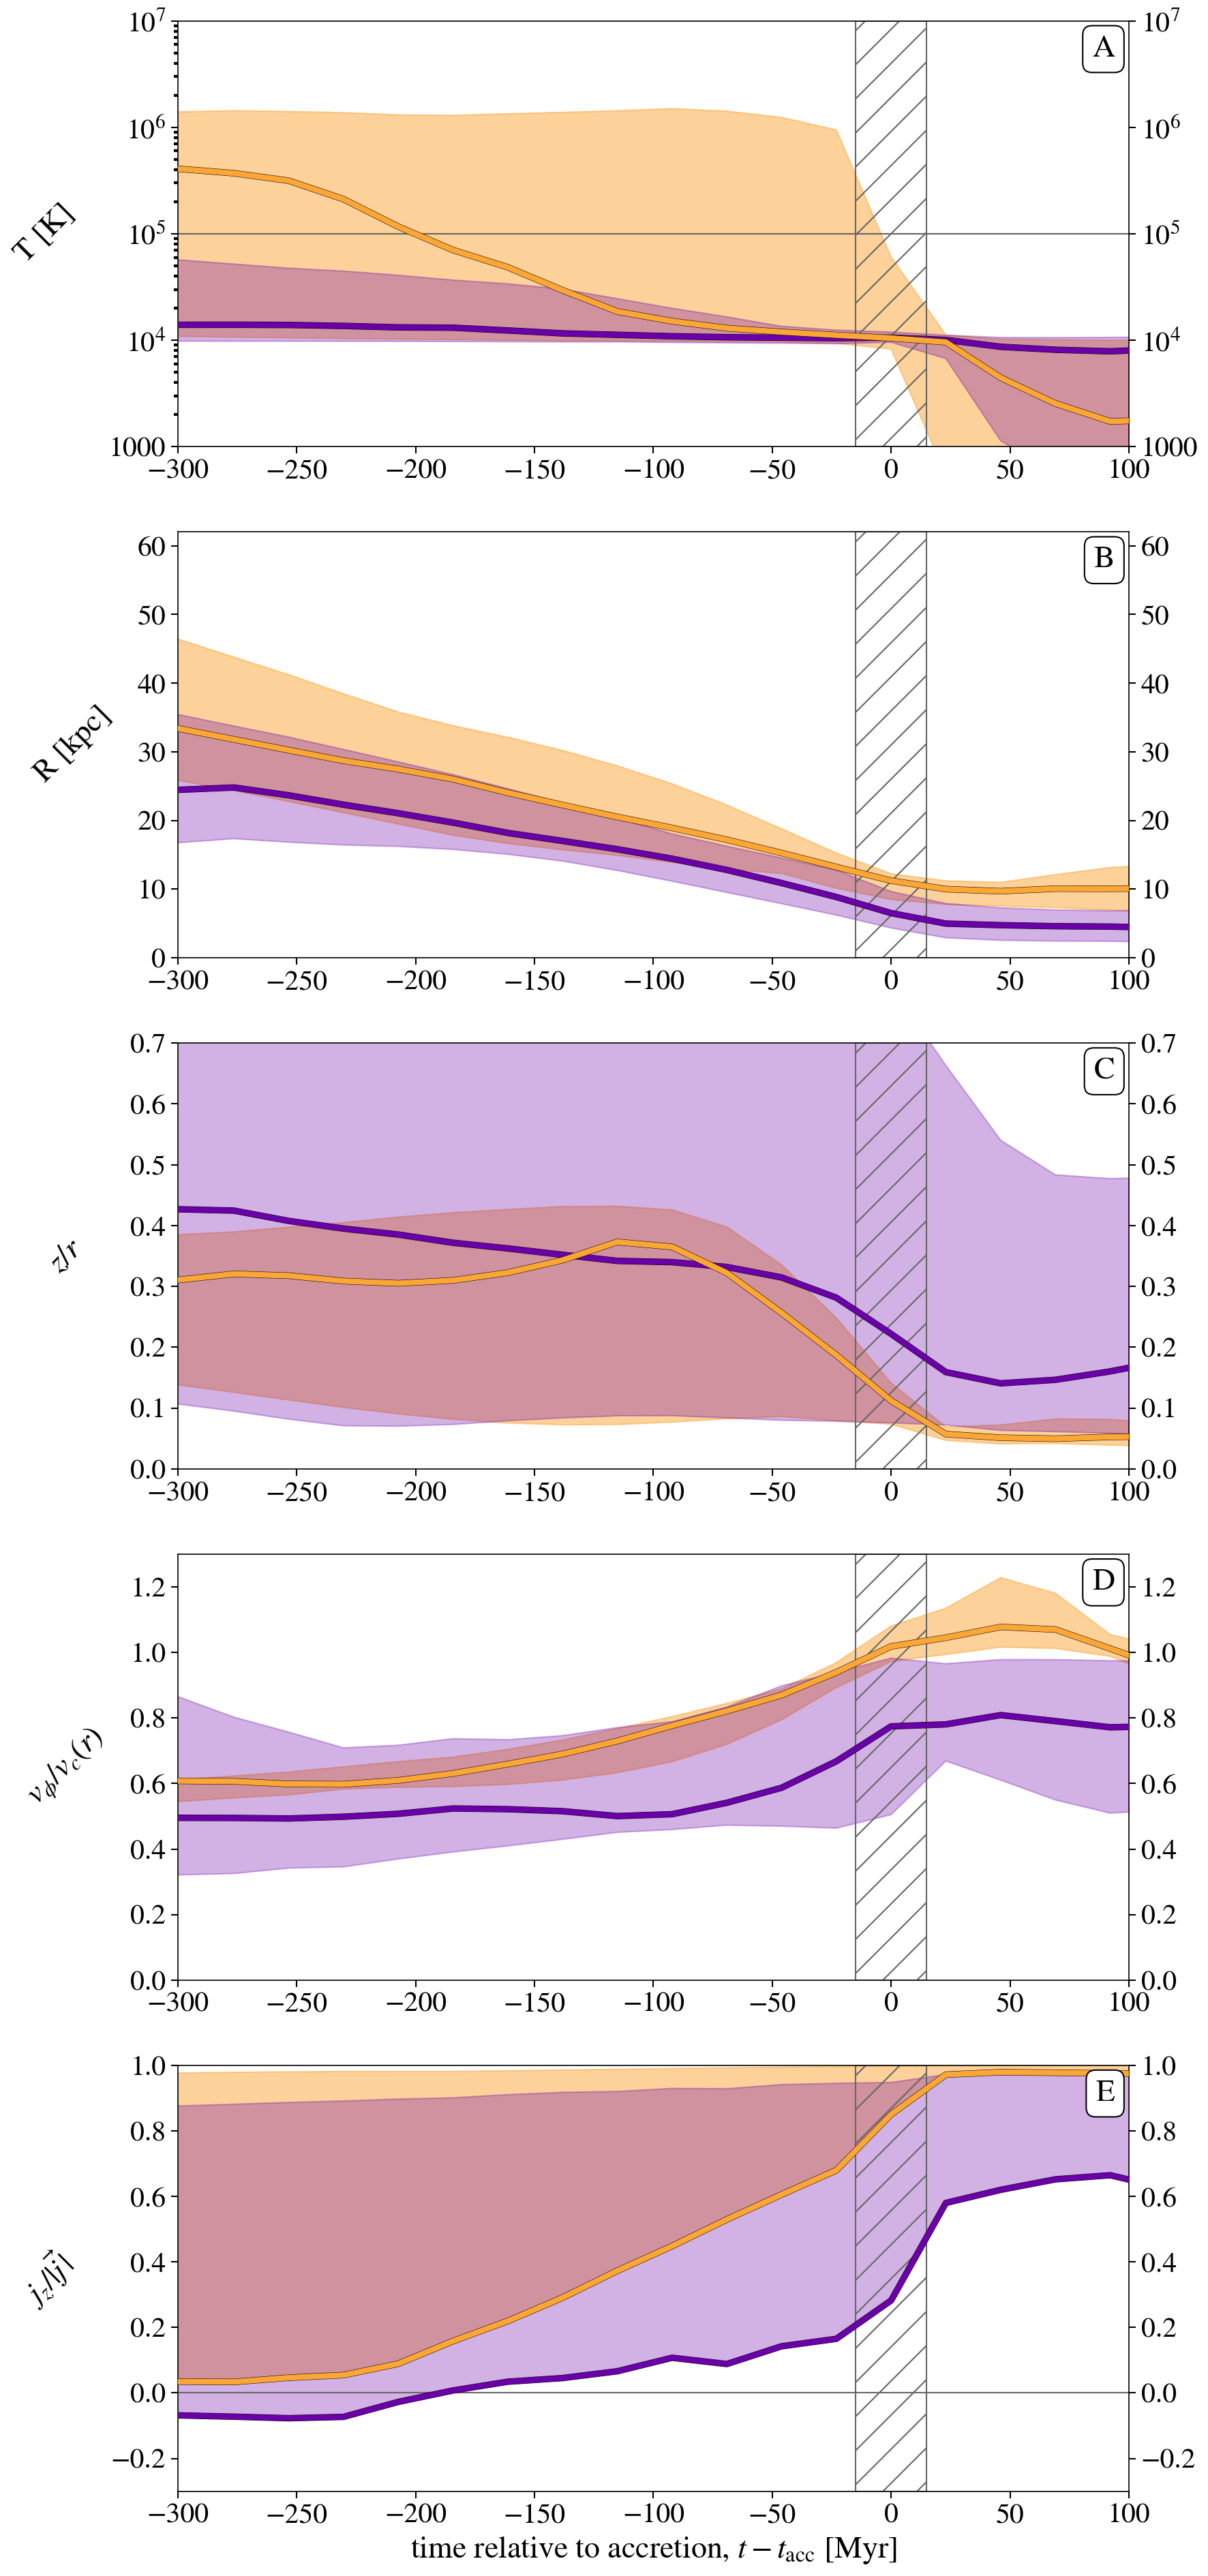

In [70]:
fig

## Save

In [71]:
plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'before_and_after' ),
    save_file = 'before_and_after_combined.pdf',
    fig = fig,
)

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/variations/relative_to_accretion/before_and_after/before_and_after_combined.pdf
